# Liouvillian learning from time-traces of random observables

This notebook demonstrates Hamiltonian and Liouvillian learning from time-traces of random observables using shadow tomography 
as introduced in Olsacher et al. *Hamiltonian and Liouvillian learning in weakly-dissipative quantum many-body systems* (2025).

We are going to learn the Hamiltonian and dissipation rates of a mock experiment using different parametrizations.

In [1]:
import numpy as np
from icecream import ic
import itertools as it
from matplotlib import pyplot as plt
import sys
sys.path.append("../")
from src.hamiltonian_learning import Ansatz, Constraint, get_times
from src.pauli_algebra import qop_mean, qop_var, QuantumOperator
from src.quantum_simulator import QuantumSimulator, QuantumState, get_random_product_states
from src.model_hamiltonians import get_hamiltonian, get_dissipators
from src.ansatz_parametrization import Parametrization, ParametrizationFunction
from src.data_statistics import DataSet
# set random seed
np.random.seed(0)

We first setup a quantum simulator that serves as our mock experiment. We choose to implement a ``XY`` model with algebraically decaying interactions, as it is often impelemented in quantum simulation experiments with trapped ions. To make the model more challenging to learn we also add a site-dependent magnetic field as well as spontaneous emission with random rates for each qubit.

The full master equation for a densit matrix $\rho$ reads
$$
\frac{d\rho}{dt}
=
-i[H,\rho]
+
\sum_{j=1}^N \gamma_j
\left(
\sigma_j^- \rho \sigma_j^+
-
\frac{1}{2}
\left\{
\sigma_j^+ \sigma_j^-,
\rho
\right\}
\right)
$$
with Hamiltonian
$$
\hat{H} = \sum_{i<j=1}^N J_{ij} (\sigma_i^x \sigma_j^x + \sigma_i^y \sigma_j^y) + \sum_{i=1}^N B_i \sigma_i^z .
$$


In [2]:
### STEP 1 ### define model and quantum simulator

# system parameters
Nqubits = 4

## algebraically decaying couplings
alpha = 1.5
J0 = 10
Jxy = np.zeros((Nqubits,Nqubits))
for i in range(Nqubits):
    for j in range(Nqubits):
        if i<j:
            dist = np.abs(i-j)
            Jxy[i,j] = J0/dist**alpha

# random magnetic field in Z direction
Bz_field = 10
Bz = Bz_field * np.random.uniform(0,1,size=Nqubits)

# spontaneous emission at random rates for each qubit
dissipation_rate = 1
dissipation_rates = dissipation_rate * np.diag(np.random.uniform(0,1,size=Nqubits))

# construct the Liouvillian for the simulated system
hamiltonian_terms = {"Jxx": Jxy, "Jyy": Jxy, "Bz": Bz}
Hsim = get_hamiltonian(Nqubits, terms=hamiltonian_terms).remove_zero_coeffs()

# construct dissipators
dissipator_rates = {"Gm": dissipation_rates}
Dsim = get_dissipators(Nqubits, dissipation_rates=dissipator_rates)

# setup quantum simulator
qsim = QuantumSimulator(Nions=Nqubits)
qsim.hamiltonian = Hsim.copy()        
qsim.dissipators = Dsim.copy()

Next we will setup the ansatz that we will use for Hamiltonian and Liouvillian learning.
Our goal is to learn the Hamiltonian ``operator_learned`` and the jump operators and their dissipation rates ``dissipators_learned``.
Errorbars for the learned parameters are estimated via bootstrapping of the rows of the constraint matrix. Here ``ansatz.n_resampling_constaints[0]`` is the ratio of rows excluded and ``ansatz.n_resampling_constaints[1]`` is the number of samples taken. We sample rows with replacement.

In [3]:
### STEP 2 ### setup ansatz for learning

# setup ansatz Hamiltonian and dissipators
ansatz = Ansatz(Nions=Nqubits)
ansatz.ansatz_operator = Hsim.copy()
ansatz.ansatz_dissipators = Dsim.copy()

# choose how often to resample rows of constraint tensors when estimating errorbars
ansatz.n_resampling_constraints = (0, 20)
ansatz.resampling_constraints_replace = True

# setup the values that should be calculated
ansatz.result_keys = ["operator_learned", "dissipators_learned"]

Learning can be performed using a parametrization of the ansatz. A parametrization can be used to exclude specific terms from the ansatz. Or to introduce dependencies between different ansatz terms.
Below we introduce two "free" parametrizations without dependencies between parameters: One that includes all terms in the Hamiltonian but no dissipation. And one that also includes the dissipation.

In [4]:
### STEP 3 ### setup parametrizations for learning

parametrizations = []

### free parametrization without dissipation
par = Parametrization()
par.name = "H"
# add parametrization functions for all terms in the Hamiltonian
par.add_functions_for_free_terms(Hsim)
parametrizations.append(par)

### free parametrization with dissipation
par_diss = Parametrization()
par_diss.name = "H + D"
# add parametrization functions for all terms in the Hamiltonian
par_diss.add_functions_for_free_terms(Hsim)
# add parametrization functions for all dissipators
par_diss.add_functions_for_free_terms(Dsim)
parametrizations.append(par_diss)

Next we set up the constraints that will be measured to learn the ansatz coefficients.
Here our goal is to learn from the time-traces of random observables called the ``contraint_operators``. 

In [5]:
### STEP 4 ### setup constraints for learning from random time-traces

## set constraint operators for learning
con_all1loc = [QuantumOperator(N=Nqubits, terms={inx*'I'+var+'I'*(Nqubits-inx-1): 1.0}) for inx in range(Nqubits) for var in 'XYZ']
con_all2loc = [QuantumOperator(N=Nqubits, terms={inx1*'I'+var1+inx2*'I'+var2+'I'*(Nqubits-inx1-inx2-2): 1.0}) for inx1 in range(Nqubits) for inx2 in range(Nqubits-inx1-1) for var1 in 'XYZ' for var2 in 'XYZ']
constraint_operators_learn = con_all1loc + con_all2loc
# ic([con.str() for con in constraint_operators_learn])

## set initial states for learning
number_of_initial_states = 4
states_learn = get_random_product_states(Nqubits, number_of_initial_states, chosen_bases=["x","z"])

## set all times that will be simulated 
total_time = 0.05 # total time 
ntimesteps = 20 # integral discretization steps
alltimes = np.linspace(0, total_time, ntimesteps)

## set timespans that will be used for learning
ntimes = 1 # number of different time constraints
times_learn = get_times(alltimes, ntimesteps, ntimes)

## generate the constraints for learning from time-traces
constraints =  [Constraint(initial_state=tmp[0],simulation_times=tmp[1],constraint_operator=tmp[2]) for tmp in it.product(states_learn, times_learn, constraint_operators_learn)]

Now we run our mock experiment in order to generate the measurement data required for learning.
Instead of taking measurements for specific constraint operators we rather measure a classical shadow, i.e., we peform multiple measurements in random product bases for each time in ``times_learn``.

Using classical shadows allows to apply Hamiltonain learning to large quantum systems of as demonstrated in ``Olsacher et al. (2025)``.

In [6]:
### STEP 5 ### generate classical shadows and add to ansatz data set

# chose total number of random basis per time step
nshots_per_time = 4000

# create classical shadow
classical_shadow = DataSet(Nions=Nqubits)
for state in states_learn:
    if len(times_learn)>1:
        raise ValueError('shadows for ntimes>1 not implemented')
    classical_shadow_state = qsim.get_classical_shadow(initial_state=state, simulation_times=alltimes, nshots_shadow=nshots_per_time) #, nshots_per_basis=cfg['nshots_per_basis'], nbases_cutoff=cfg['nbases_cutoff'], required_operator_initial_time=required_operator, nshots_ratio_integrand=1/ntimes_max, skip_initial_time=cfg['exact_initial_values'])
    classical_shadow.add_data_set(classical_shadow_state)

# count total number of measurements taken
nshots_total = classical_shadow.get_nruns()

# add classical shadow to ansatz data set
ansatz.data_set.add_data_set(classical_shadow)

We plot an example time-trace to check if there are enough time-steps points for numerical integration over time, as is required for learning.

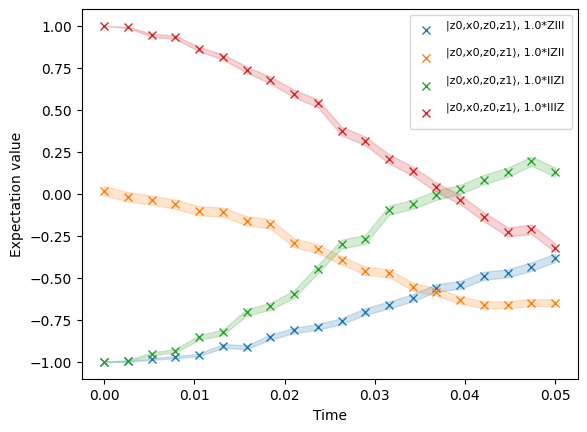

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Time', ylabel='Expectation value'>)

In [7]:
### STEP 6 ### check time dynamics of observables from data set

qops = [QuantumOperator(N=Nqubits, terms={"ZIII":1.0}), QuantumOperator(N=Nqubits, terms={"IZII":1.0}), QuantumOperator(N=Nqubits, terms={"IIZI":1.0}), QuantumOperator(N=Nqubits, terms={"IIIZ":1.0})]
ansatz.data_set.plot_time_dynamics(observables=qops, nshots=-1, errorbars=True, states=[states_learn[0]])

Next we calculate the constraint tensors from the data.

In [8]:
### STEP 7 ### calculate the constraint tensors for learning

# construct the constraint tensors for learning
ansatz.get_constraint_tensors(constraints=constraints, label='learn', method='BAL', nshots=-1) #, Gaussian_noise=cfg['Gaussian_noise'], constraints=constraints_learn, exact_initial_values=cfg['exact_initial_values'], required_terms=required_terms)

# check the constructed constraint tensors
ic(ansatz.constraint_tensors.keys())

ic| pstr_get_con_tens: 'automatically determine required terms for BAL method'
ic| ansatz.constraint_tensors.keys(): dict_keys([('learn', 'BAL', -1)])


dict_keys([('learn', 'BAL', -1)])

Finally we perform the learning for all parametrizations and different number of measurements used.
We then extract the results from the ansatz.result attribute.

In [9]:
### STEP 8 ### learn the ansatz coefficients and extract results

### learn the Hamiltonian and dissipators
ansatz.learn(learn_method="BAL", nshots=-1, parametrizations=parametrizations)

### extract the results
# learned Hamiltonian (normalized)
ansatz.plotdata["Hlearn"] = [qop_mean([abs(learnop) for learnop in ansatz.result[("BAL",-1)].operator_learned[parinx]]) for parinx in range(len(parametrizations))]
ansatz.plotdata["var_Hlearn"] = [qop_var([abs(learnop) for learnop in ansatz.result[("BAL",-1)].operator_learned[parinx]]) for parinx in range(len(parametrizations))]
# learned dissipators
if ansatz.ansatz_dissipators is not None:
    ansatz.plotdata["Dlearn"] = [np.mean([[diss.coeff for diss in diss_samp] for diss_samp in ansatz.result[("BAL",-1)].dissipators_learned[parinx]],axis=0) for parinx in range(len(parametrizations))]  
    ansatz.plotdata["var_Dlearn"] = [np.var([[diss.coeff for diss in diss_samp] for diss_samp in ansatz.result[("BAL",-1)].dissipators_learned[parinx]],axis=0) for parinx in range(len(parametrizations))]

ic| pstr_learn: 'enter learn method BAL with nshots -1 and 1 cpus'
ic| pstr_resampling: 'number of samples taken for errorbars is 20'
Processing samples for errorbars: 100%|██████████| 20/20 [00:00<00:00, 302.36it/s]


We plot the learned Hamiltonian parameters and dissipation rates against the parameters of the quantum simulator.

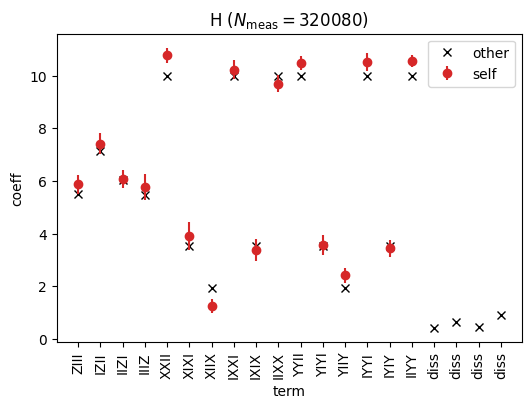

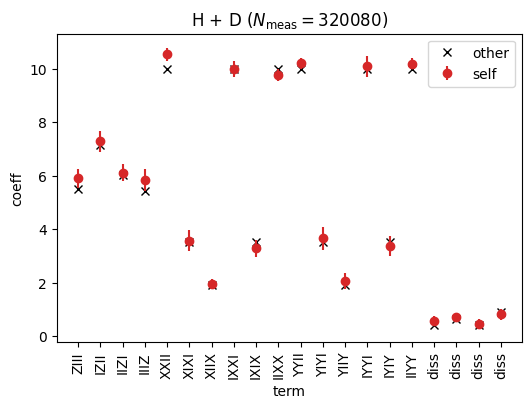

In [10]:
### STEP 9 ### plot learned Hamiltonian and dissipators

tmp_parinx_list_plot = list(range(len(parametrizations)))
tardiss = [diss.coeff for diss in Dsim]

### plot learned Hamiltonian
for parinxinx, parinx in enumerate(tmp_parinx_list_plot):
    tmpop = ansatz.plotdata["Hlearn"][parinx].remove_zero_coeffs()
    var_tmpop = ansatz.plotdata["var_Hlearn"][parinx]
    tmpdiss = None
    var_tmpdiss = None
    if ansatz.ansatz_dissipators is not None:
        tmpdiss = ansatz.plotdata["Dlearn"][parinx]
        var_tmpdiss = ansatz.plotdata["var_Dlearn"][parinx]
    plotlabel = r"{} ($N_\mathrm{{meas}}={})$".format(parametrizations[parinx].name, nshots_total)
    tmpop.plot(var=var_tmpop, other=Hsim, add_labels=True, title=plotlabel, dissrates=tmpdiss, var_dissrates=var_tmpdiss, other_dissrates=tardiss)